### RdNBR to Geotiff
Created by Amos Bennett.<br>
Last Updated 23 Sep 20. <br>

__Updates:__ 

Generates a RdNBR from pre and post fire Sentinel 2a/b analysis ready scenes. Uses custom memory control.

In [1]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datacube.utils import cog
import math as m
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/554/ab4513/dea-notebooks/Scripts")
import dea_datahandling
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
print(datacube.__version__)

1.8.2


In [3]:
dc = datacube.Datacube(app="dNBR")

In [4]:
# Set the central latitude and longitude
central_lat = -35.783333
central_lon = 148.016667
crs = 'EPSG:32755'

# Canberra 148.6547665°E 35.5655761°S
# Kosciuszko 148.3517111°E 36.1864717°S
# Tumbarumba 148.016667°E 35.783333°S

# 0.1° approximately equal to 11.1km distance.

# Set the buffer to load around the central coordinates (even numbers such as 0.2, 1.0, 2.2 etc) in degrees (lat, lon)
buffer = 0.6

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

In [5]:
import shapely
from shapely.geometry import Point

# Create a range for generating point grid.
magic_number = int(buffer*10/1)
rng = range(int(magic_number/2))

x_coord = []
y_coord = []

# Calculate x and y for point grid.
for i in rng:
    l = i/5 + 0.1
    neg_lat = central_lat - l
    neg_lon = central_lon - l
    pos_lat = central_lat + l
    pos_lon = central_lon + l
    x_coord.append(neg_lon)
    x_coord.append(pos_lon)
    y_coord.append(neg_lat)
    y_coord.append(pos_lat)
    
coords = []

# Create list of shapely points.
for x in x_coord:
    for y in y_coord:
        p = Point(x, y)
        coords.append(p)

In [6]:
# Key Dates
prefire_start = '2019-11-01'
prefire_end = '2020-01-06'
postfire_start = '2020-01-07'
postfire_end = '2020-05-01'

In [7]:
# Print dates
print('start_date_pre:  '+prefire_start)
print('end_date_pre:    '+prefire_end)
print('start_date_post: '+postfire_start)
print('end_date_post:   '+postfire_end)

start_date_pre:  2019-11-01
end_date_pre:    2020-01-06
start_date_post: 2020-01-07
end_date_post:   2020-05-01


In [34]:
def RdNBR_processing(coordinates):
    
    # Load all data in baseline period available from s2a/b_ard_granule datasets
    prefire_ard = load_ard(dc=dc,
                  products=['s2a_ard_granule', 's2b_ard_granule'],
                  x = (coordinates.x - 0.1, coordinates.x + 0.1),
                  y = (coordinates.y - 0.1, coordinates.y + 0.1),
                  time=(prefire_start, prefire_end),
                  measurements=['nbart_nir_1',
                                'nbart_swir_3'],
                  min_gooddata=0.1,
                  output_crs='EPSG:32755', # UTM Zone 55S
                  resolution=(-10,10),
                  group_by='solar_day')
   
    prefire_ard = calculate_indices(prefire_ard,
                                    index='NBR', 
                                    collection='ga_s2_1', 
                                    drop=False)

    # Compute median using all observations in the dataset along the time axis
    prefire_image = prefire_ard.median(dim='time')

    # Delete baseline_combined
    del prefire_ard

    # Select NBR
    prefire_NBR = prefire_image.NBR
    
    del prefire_image
    
    abs_prefire_NBR = abs(prefire_NBR)

    # Load all data in post-fire period available from s2a/b_ard_granule datasets
    postfire_ard = load_ard(dc=dc,
                   products=['s2a_ard_granule', 's2b_ard_granule'],
                   x = (coordinates.x - 0.1, coordinates.x + 0.1),
                   y = (coordinates.y - 0.1, coordinates.y + 0.1),
                   time=(postfire_start, postfire_end),
                   measurements=['nbart_nir_1',
                                 'nbart_swir_3'],
                   min_gooddata=0.1,
                   output_crs='EPSG:32755', # UTM Zone 55S
                   resolution=(-10,10),
                   group_by='solar_day')

    # Calculate NBR on all post-fire images
    postfire_ard = calculate_indices(postfire_ard,
                                     index='NBR',
                                     collection='ga_s2_1',
                                     drop=False)

    # Calculate the median post-fire image
    postfire_image = postfire_ard.median(dim='time')

    del postfire_ard
    
    # Select NBR
    postfire_NBR = postfire_image.NBR

    del postfire_image

    # Calculate delta
    dNBR = prefire_NBR - postfire_NBR

    del prefire_NBR
    del postfire_NBR
    
    # Calculate relative delta
    RdNBR = (dNBR)/xr.ufuncs.sqrt(abs_prefire_NBR)
    
    del dNBR
    del abs_prefire_NBR
    
    x = np.round_(coordinates.x, decimals=4)
    y = np.round_(coordinates.y, decimals=4)

    # Turn RdNBR into a x-array dataset for export to GeoTIFF
    RdNBR_dataset = RdNBR.to_dataset(name='RdNBR')
    # cog.write_cog(dnbr_dataset, './NBR_geotiffs/{x}_{y}_dNBR.tif')
    write_geotiff(f'./RdNBR_geotiffs/{x}_{y}_RdNBR.tif', RdNBR_dataset)
        
    del RdNBR_dataset

In [36]:
%%time

# Iterate through all shapely points to generate a dNBR geotiff.
for i in coords:
    RdNBR_processing(i)

Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 21 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 
Loading s2a_ard_granule data
    Filtering to 10 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 25 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 32 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 11 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 20 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 11 out of 21 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 6 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 7 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 16 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 22 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 21 observations 
Loading s2a_ard_granule data
    Filtering to 12 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 12 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 9 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 19 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 7 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 14 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 7 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 16 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 11 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 28 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 10 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 22 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 18 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 10 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 7 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 29 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 11 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 24 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 4 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 5 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 12 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 5 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 12 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 5 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 12 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 10 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 18 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 6 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 5 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 11 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 12 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 7 out of 7 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 5 out of 6 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 12 observations 
Loading s2a_ard_granule data
    Filtering to 8 out of 11 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 17 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 21 observations 
Loading s2a_ard_granule data
    Filtering to 12 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 16 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 28 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 14 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 9 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 23 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 15 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 28 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 21 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 14 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 27 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 11 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 11 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 22 observations 
Loading s2a_ard_granule data
    Filtering to 13 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 30 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 12 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 8 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 20 observations 
Loading s2a_ard_granule data
    Filtering to 16 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 33 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


Loading s2a_ard_granule data
    Filtering to 13 out of 14 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 11 out of 12 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 24 observations 
Loading s2a_ard_granule data
    Filtering to 14 out of 22 observations
    Applying pixel quality mask
Loading s2b_ard_granule data
    Filtering to 17 out of 23 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 31 observations 


/g/data/v10/public/modules/dea/20200713/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


CPU times: user 34min 7s, sys: 8min 51s, total: 42min 59s
Wall time: 18min 49s


In [37]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import glob
import os

In [38]:
dirpath = r"/home/554/ab4513/dea-notebooks/My Notebooks/RdNBR_geotiffs"
out_fp = r"/home/554/ab4513/dea-notebooks/My Notebooks/RdNBR_geotiffs/Tumbarumba_RdNBR.tif"

# Make a search criteria to select the DEM files
search_criteria = "1*.tif"
q = os.path.join(dirpath, search_criteria)
print(q)

/home/554/ab4513/dea-notebooks/My Notebooks/RdNBR_geotiffs/1*.tif


In [39]:
dem_fps = glob.glob(q)

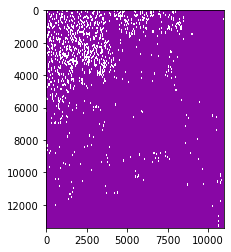

In [40]:
src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)
    
src_files_to_mosaic

mosaic, out_trans = merge(src_files_to_mosaic)
show(mosaic, cmap='plasma')

In [41]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": crs})

with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)